In the last exercise, we used an Erdös-Rényi random attachment model to analyze how interconnections influence the spread of illness over space. Erdös-Rényi, however, is not the only model that exists, and others, such as Preferential Attachment Networks, have the advantage of being more true to reality and an even closer representation of reality.

In these models, unlike in the random models, there is a preference when forming links between nodes: normally, nodes tend to cluster around the nodes with the largest number of linked nodes, promoting centralization and improving the connection between nodes; in this way, for example, the diameter of the network tends to decrease, since most nodes can be connected by traveling to the "mother node". 

This model, theorized by Barabási and Albert in 2000, works with an initial grid full of vertices, which are connected either to each other or to a larger node according to a series of possibilities.

To begin with, we will import the necessary modules:

In [1]:
import numpy as np                  #Supports common numeric operations
import matplotlib.pyplot as plt     #For graphs
import networkx as nx               #For the creation, manipulation, and study of complex networks.
import time, datetime               #To check how long the script takes to run

To make the task easier to work with, we will also import some of the functions from the previous section:

In [2]:
def erdos_renyi(nodes, link_prob):
    x = np.zeros((nodes, nodes),int) #start with n vertices
    for i in range(nodes):
        for j in range(nodes):
            if np.random.uniform(0, 1) < link_prob:
                x[i,j] = x[j,i] = 1
    return(x)

In [3]:
def plot_adjacency(adjacency_matrix):
    gr = nx.from_numpy_matrix(adjacency_matrix)
    mylabels = dict(zip(range(len(adjacency_matrix)), range(len(adjacency_matrix))))
    nx.draw(gr, node_size=200, edge_cmap = "Greys", labels=mylabels, with_labels=True)
    return nx.diameter(gr)

And now, we can define the functions that will help us generate the preferential attachment network:

In [4]:
def preferential_attachment(nodes, links_per_newnode):
    x = np.zeros((nodes, nodes),int) #start with n vertices
    bonds = np.zeros(nodes,int)
    for i in range(1, links_per_newnode):
        for j in range(1, nodes-1):
            x[i,j] = x[j,i] = 1
            bonds[i] += 1; bonds[j] += 1
            
    for i in range(links_per_newnode + 1, nodes):
        prob = bonds / np.sum(bonds)
        for n in range(1, links_per_newnode):
            r = np.random.uniform(0, 1)
            cum_p = 0; j = 0
            while cum_p < r:
                j += 1; cum_p += prob[j]
            x[i,j] = x[j,i] = 1
            bonds[i] += 1; bonds[j] += 1
            prob[j] = 0
            prob = prob / np.sum(prob + 1e-7) #+ 1e-7 so that it doesnt produce an error
    return(x)

And a 2D-lattice network; this I have done using only networkx, since I am so short on time I cant afford to think how to do it.

To see how our graphs went, we would like to plot them; but, first, we need to select only the biggest component:

In [5]:
def purge(adjacency_matrix):
    graph = nx.from_numpy_matrix( adjacency_matrix )
    sub_graph = graph.subgraph( (sorted(nx.connected_components(graph), key=len, reverse=True))[0] )
    return nx.to_numpy_matrix( sub_graph )

And now, we can plot:

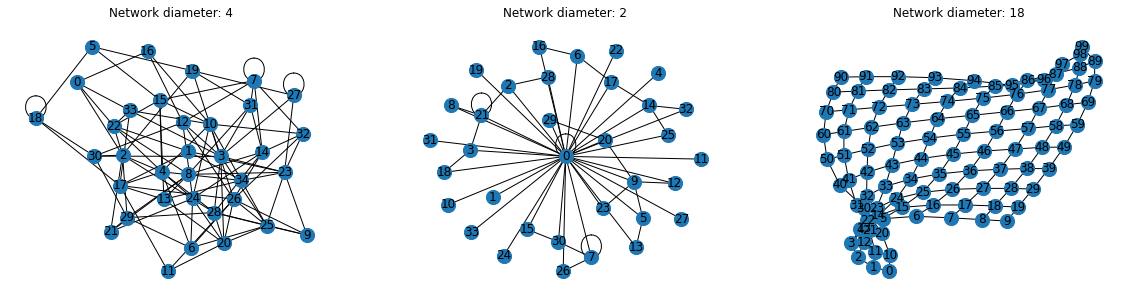

In [11]:
lattice_graph = nx.grid_2d_graph(10,10) 
plt.subplots(figsize=(20, 5))
plt.subplot(1, 3, 1)
d = plot_adjacency( purge(erdos_renyi(35, 0.1)) ); plt.title(f"Network diameter: {d}")
plt.subplot(1, 3, 2)
d = plot_adjacency( purge(preferential_attachment(35, 2)) ); plt.title(f"Network diameter: {d}")
plt.subplot(1, 3, 3)
d = plot_adjacency( purge(nx.to_numpy_matrix( lattice_graph ))  ); plt.title(f"Network diameter: {d}")
plt.show()

In the above graphs, one can clearly see the difference betweeen the three topologies: one has completely random edges, with most nodes exhibiting a similar number of conections and none clearly predominating. The network diameter is 4, which is small but not as small as in the preferential attachment network (diameter 2), where most nodes can be easily connected through the middle one. Finally, the 2D-lattice has the biggest diameter (18) as there are no shortcuts and one must traverse lots of nodes to get from one place to another.

To better understand how the structure affects outcome, lets carry out a numerical simulation of a rumor propagation process that starts with a single individual carrying a hot piece of news. At each time step, individuals will pass the rumour to their neighbors with probability 𝛽 (per neighbor), and they will stop propagating the network with probability 𝜇. We will compare these three structures with the mean-field solution, which is propagation at a constant speed given by the average number of contacts.

We define the propagating function:

In [6]:
def propagate_rumour(adjacency_matrix, pass_it = 0.3, ignore = 0.001, iterations = 1000):
    my_graph = nx.from_numpy_matrix(adjacency_matrix)
    new_infected = dict(zip(range(len(my_graph)), np.zeros(len(my_graph))))
    infected_overtime = [1]; new_infected[np.random.randint(len(my_graph))] = 1
    for t in range(iterations-1):
        infected = new_infected
        for element in range(len(my_graph)): #For each of the elemets of the graph
            for neighbor in my_graph.neighbors(element): #Find its neighbors
                p = np.random.uniform(0,1)
                if p >= ignore:
                    if infected[element] == 1 and p < pass_it and infected[neighbor] != None:
                        new_infected[neighbor] = 1
                else:
                    new_infected[element] = None
                    infected[element] = None
        counter = [1 if x == 1 else 0 for x in new_infected.values()] #Cannot sum "None"
        infected_overtime.append(sum(counter))
        if sum(counter) == 0: return infected_overtime, t
    return infected_overtime

And we run the simulations 1000 times for up to 1000 steps. Please note that this cell can take suuuuuuper long to run, since it is doing 1000x1000 repetitions. Please, bear in mind that, in my computer, it took 1 full hour to run.

In [7]:
erdos_endpoint = preferential_endpoint = lattice_endpoint = []
print(datetime.datetime.now())
for repetition in range(1000):
    print(f"Repetition #{repetition}", end = "\r", flush=True)
    erdos_endpoint.append(propagate_rumour(purge(erdos_renyi(100, 0.1)))[1])
    preferential_endpoint.append(propagate_rumour(purge(preferential_attachment(100, 3)))[1])
    lattice_endpoint.append(propagate_rumour(nx.to_numpy_matrix(nx.grid_2d_graph(10,10)))[1])
print(datetime.datetime.now())

2021-12-14 16:22:29.960008
2021-12-14 17:12:37.746489


And we plot some histograms. Please note that I reduced the number of bins from 1000 to 100, since what I want to look at is not the precise distribution by exact time of ending, but rather a general idea about whether the simulation ends prematurely, towards the middle, at the end, or does not finish at all by the time of reporting.

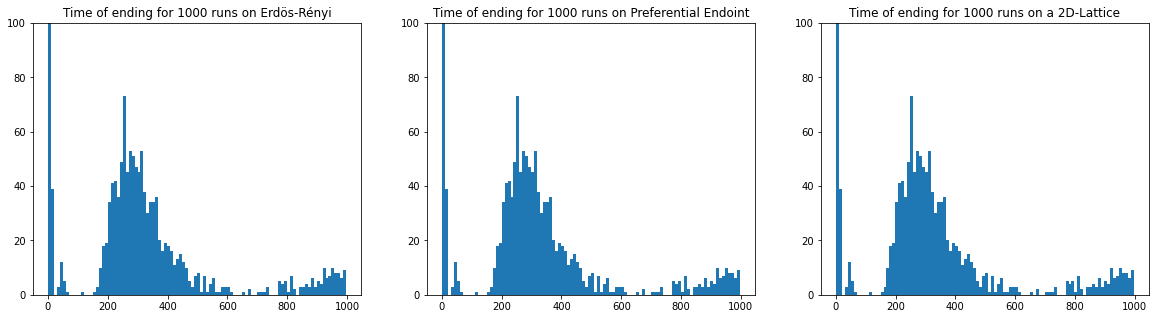

In [37]:
plt.subplots(figsize=(20, 5))
plt.subplot(1, 3, 1); plt.ylim(0, 100)
plt.hist(erdos_endpoint, bins = 100); plt.title("Time of ending for 1000 runs on Erdös-Rényi");
plt.subplot(1, 3, 2); plt.ylim(0, 100)
plt.hist(preferential_endpoint, bins = 100); plt.title("Time of ending for 1000 runs on Preferential Endoint");
plt.subplot(1, 3, 3); plt.ylim(0, 100)
plt.hist(lattice_endpoint, bins = 100); plt.title("Time of ending for 1000 runs on a 2D-Lattice");
plt.show()

What we can see is that, in fact, the three gaphs are quite similar, if not identical. Part of this has to do with the reduction in the number of bins (grouping in groups of 10 necessarily reduces resolution), but part of this must also have to do with the underlying mechanisms of the data. This has greatly surprised me: I would have expected the Preferentially-attached network to be at least more rumour-prone than the erdos-renyi one, and I would have expected the 2D-lattice to provide a middle ground between them, maybe with rumours spreading for longer given that the network diameter is so large. That this didn't happen seems to contradict my hypothesis from the last exercise, that network topology is determinist towards what will happen; of course, this could also be just an artifact due to the different enunciados. I dont know.

Anyways, with regards to the found results, we can clearly identify three groups:

* **Early finishers**: Actually, most of the trajectories in all networks end at some point between 1 and ~10 repetitions, so much so that I have been forced to cut the y-axis so that the rest of the endpoints could be seen. This has surprised me, but it actually makes sense: I selected such an small transmission value *0.3*, that it is actually quite difficult for local *cotillas* to spread the word, specially since most of the nodes have an average of ~3 joined nodes. This was made on purpouse, no make the networks comparable, but, since $3 \cdot 0.3 = 1$, it is actually difficult to spread things over.
* **The fading fashion**: For those rumours that manage to break out, there seems to be a normal-like distribution centered around $t = 300$: The rumour spreads for some time, until all individuals become inmune, and then it dies out.
* **The enduring cult**: Some rumours manage to fo even further, trespassing a "barrier" around 800 to live for longer, and maybe even perdure over time: around 20 simulations hadn't actually ended by the time of reporting.

Since the initial individual was selected at random, we can for sure say that this is not a relevant factor on the outcome: what, then, decides whether a rumour spreads out or not? What defines, then, wether an individual survives or not? With the graphs and the information that I have, I am sadly forced to say that this must be pure chance: if it was network topology, some differences would have been observed between the three histograms.

Another option is that network topology **is relevant** on the small scale, but that, with such a big number of repetitions, that variability becomes less relevant, forcing the model to "collapse" around the explained groups.